# Practice overturning calculation

`cd project/seniorthesis/notebooks`

`conda list PyCO2SYS`

`pip install PyCO2SYS`

`pip install git+https://github.com/jbusecke/cmip6_preprocessing.git`

`mv *.png ../figures`

In [1]:
import xarray as xr
import xesmf as xe
from cmip6_preprocessing.preprocessing import combined_preprocessing
# import PyCO2SYS as pyco2 # i have to install this package through terminal for it to work
import intake
import matplotlib.pyplot as plt
import numpy as np
import warnings
import gsw
from cmip6_preprocessing.postprocessing import combine_datasets
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.path as mpath
from cmip6_preprocessing.postprocessing import combine_datasets
from cmip6_preprocessing.postprocessing import merge_variables
from dask.diagnostics import ProgressBar
from xgcm import Grid
from xhistogram.xarray import histogram
import pandas as pd
import scipy

from xgcm.autogenerate import generate_grid_ds

from cmip6_preprocessing.postprocessing import match_metrics


In [2]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

def pick_first_member(ds_list, **kwargs):
    return ds_list[0]

# Get IPSL
I choosing `Odec` because regridding and time averaging `Omon` overloads the kersel

In [3]:
cat = col.search(
    source_id = 'IPSL-CM6A-LR',
    member_id = 'r1i1p1f1',
    experiment_id = 'historical',
    table_id = 'Odec',
    variable_id= ['vo', 'thetao', 'so'],
    grid_label = 'gn'
)
ddict = cat.to_dataset_dict(zarr_kwargs={'consolidated':True, 'use_cftime':True},preprocess=combined_preprocessing, aggregate=False)
ddict = merge_variables(ddict)

def pick_first_member(ds_list, **kwargs):
    return ds_list[0]

ddict = combine_datasets(
    ddict,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


## Regrid

In [4]:
# Regrid
targetgrid_ds = xe.util.grid_global(1.0, 1.0)
targetgrid_ds['lon'] = targetgrid_ds['lon']+180
targetgrid_ds['lon_b'] = targetgrid_ds['lon_b']+180
newcoords = {'x':targetgrid_ds['lon'][0,:],'y':targetgrid_ds['lat'][:,0]}

dd_vo={}
for name,item in ddict.items():
    regridder = xe.Regridder(item, targetgrid_ds, 'bilinear', 
                         periodic=True, ignore_degenerate=True)
    ds_regridded = regridder(item).assign_coords(**newcoords).chunk({'time':120,'lev':1})
    dd_vo[name]=ds_regridded
list(dd_vo.keys())

['IPSL-CM6A-LR.gn.historical.Odec']

## ds is IPSL entry in the dictionary in depth coords

In [37]:
ds = dd_vo['IPSL-CM6A-LR.gn.historical.Odec']
ds

<xarray.Dataset>
Dimensions:      (y: 180, x: 360, time: 16, lev: 75, bnds: 2, lev_outer: 76)
Coordinates:
  * lev          (lev) float32 0.512 1.564 2.677 ... 5.698e+03 5.902e+03
    lev_bounds   (lev, bnds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
  * time         (time) object 1855-01-01 00:00:00 ... 2005-01-01 00:00:00
    time_bounds  (time, bnds) object dask.array<chunksize=(16, 2), meta=np.ndarray>
    lon          (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
    lat          (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
  * x            (x) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * y            (y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lev_outer    (lev_outer) float32 0.0 1.024 2.103 ... 5.8e+03 6.004e+03
Dimensions without coordinates: bnds
Data variables:
    area         (y, x) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
    thetao       (time, lev, y, x) float32 dask.array<chunksize=(16, 1, 180, 360), meta=np.ndarray>
    vo           (time, lev, y, x) float32 dask.array<chunksize=(16, 1, 180, 360), meta=np.ndarray>
    so           (time, lev, y, x) float32 dask.array<chunksize=(16, 1, 180, 360), meta=np.ndarray>
    sigma0       (time, lev, y, x) float64 dask.array<chunksize=(16, 1, 180, 360), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

## Calculate `sigma0`


In [38]:

# for name, ds in dd_vo.items():
# dd_vo['p'] = gsw.p_from_z(-1*ds['lev'], ds['y'], geo_strf_dyn_height=0, sea_surface_geopotential=0)*xr.ones_like(ds['talk']) # expand along time dimension
# dd_vo['insitutemp'] = gsw.t_from_CT(ds['so'], ds['thetao'], ds['p'])
ds['sigma0'] = gsw.sigma0(ds['so'],ds['thetao'])


In [39]:
ds

<xarray.Dataset>
Dimensions:      (y: 180, x: 360, time: 16, lev: 75, bnds: 2, lev_outer: 76)
Coordinates:
  * lev          (lev) float32 0.512 1.564 2.677 ... 5.698e+03 5.902e+03
    lev_bounds   (lev, bnds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
  * time         (time) object 1855-01-01 00:00:00 ... 2005-01-01 00:00:00
    time_bounds  (time, bnds) object dask.array<chunksize=(16, 2), meta=np.ndarray>
    lon          (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
    lat          (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
  * x            (x) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * y            (y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lev_outer    (lev_outer) float32 0.0 1.024 2.103 ... 5.8e+03 6.004e+03
Dimensions without coordinates: bnds
Data variables:
    area         (y, x) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
    thetao       (time, lev, y, x) float32 dask.array<chunksize=(16, 1, 180, 360), meta=np.ndarray>
    vo           (time, lev, y, x) float32 dask.array<chunksize=(16, 1, 180, 360), meta=np.ndarray>
    so           (time, lev, y, x) float32 dask.array<chunksize=(16, 1, 180, 360), meta=np.ndarray>
    sigma0       (time, lev, y, x) float64 dask.array<chunksize=(16, 1, 180, 360), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

# Functions from Graeme

In [11]:


# Get some more grid information
# (and correct the lev variable
# so that it is actually between
# lev_bounds)

# Separately calculate dx and dy
def _degrees_to_meters(dlon, dlat, lon, lat):
        """Converts lat/lon differentials into distances in meters
        PARAMETERS
        ----------
        dlon : xarray.DataArray longitude differentials
        dlat : xarray.DataArray latitude differentials
        lon  : xarray.DataArray longitude values
        lat  : xarray.DataArray latitude values
        RETURNS
        -------
        dx  : xarray.DataArray distance inferred from dlon
        dy  : xarray.DataArray distance inferred from dlat
        """

        distance_1deg_equator = 111000.0
        dx = dlon * np.cos(np.deg2rad(lat)) * distance_1deg_equator
        dy = ((lon * 0) + 1) * dlat * distance_1deg_equator
        return dx, dy

def get_xgcm(ds,gridlon='x',gridlat='y',gridlev='lev',periodic=None):
    ''' Generate metrics and grid locations'''

    ds = generate_grid_ds(ds, {'X':gridlon,'Y':gridlat})
    xgrid = Grid(ds, periodic=periodic)

    # Get horizontal distances
    dlonG = xgrid.diff(ds[gridlon], 'X', boundary_discontinuity=360)
    dlonC = xgrid.diff(ds[gridlon+'_left'], 'X', boundary_discontinuity=360)

    dlatG = xgrid.diff(ds[gridlat], 'Y', boundary='fill', fill_value=np.nan)
    dlatC = -xgrid.diff(ds[gridlat+'_left'], 'Y', boundary='fill', fill_value=np.nan)

    ds['dxG'], ds['dyG'] = _degrees_to_meters(dlonG, dlatG, ds[gridlon], ds[gridlat])
    ds['dxC'], ds['dyC'] = _degrees_to_meters(dlonC, dlatC, ds[gridlon], ds[gridlat])
    
    # Get vertical distances
    ds['dz'] = ds['lev_bounds'].diff('bnds').squeeze()
    
    # Get area
    ds['areacello'] = ds['dxC']*ds['dyC']
    
    # Regenerate grid
    coords = {
        'X':{'center':gridlon,'left':gridlon+'_left'},
        'Y':{'center':gridlat,'left':gridlat+'_left'},
        'Z':{'center':gridlev,'outer':gridlev+'_outer'}
    }
    metrics = {
        'X':['dxC','dxG'],
        'Y':['dyC','dyG'],
        'Z':['dz'],
        ('X','Y'):['areacello']
    }
    
    xgrid = Grid(ds,coords=coords,metrics=metrics,periodic=periodic)
    
    return ds,xgrid

def get_xgcm_special(ds,gridlon='x',gridlat='y',gridlev='lev',periodic=None):
    ''' Generate metrics and grid locations
        This is a hacked version to specify "outer" coordinates for y,
        for use with transform method.'''

    ds = generate_grid_ds(ds, {'X':gridlon,'Y':gridlat})
    lat_left = np.append(ds[gridlat+'_left'],ds[gridlat+'_left'].isel(y_left=-1)+1)
    ds = ds.assign_coords({gridlat+'_left':lat_left})
    coords = {
        'X':{'center':gridlon,'left':gridlon+'_left'},
        'Y':{'center':gridlat,'outer':gridlat+'_left'}
    }
    xgrid = Grid(ds, coords=coords, periodic=periodic)

    # Get horizontal distances
    dlonG = xgrid.diff(ds[gridlon], 'X', boundary_discontinuity=360)
    dlonC = xgrid.diff(ds[gridlon+'_left'], 'X', boundary_discontinuity=360)

    dlatG = xgrid.diff(ds[gridlat], 'Y', boundary='fill', fill_value=np.nan)
    dlatC = -xgrid.diff(ds[gridlat+'_left'], 'Y', boundary='fill', fill_value=np.nan)

    ds['dxG'], ds['dyG'] = _degrees_to_meters(dlonG, dlatG, ds[gridlon], ds[gridlat])
    ds['dxC'], ds['dyC'] = _degrees_to_meters(dlonC, dlatC, ds[gridlon], ds[gridlat])
    
    # Get vertical distances
    ds['dz'] = ds['lev_bounds'].diff('bnds').squeeze()
    
    # get area
    ds['areacello'] = ds['dxC']*ds['dyC']
    
    # Regenerate grid
    coords = {
        'X':{'center':gridlon,'outer':gridlon+'_left'},
        'Y':{'center':gridlat,'outer':gridlat+'_left'},
        'Z':{'center':gridlev,'outer':gridlev+'_outer'}
    }
    metrics = {
        'X':['dxC','dxG'],
        'Y':['dyC','dyG'],
        'Z':['dz'],
        ('X','Y'):['areacello']
    }
    
    xgrid = Grid(ds,coords=coords,metrics=metrics,periodic=periodic)
    
    return ds,xgrid

# Apply functions to get more grid information
> `lev_outer`

> `y_left`

> `xleft`

> `dz`

> `dz3d`

> `sigma0_outer3d`

> `sigma0_outer2d`

In [40]:

target = np.linspace(26, 28, 60)

# for name, ds in dd_CESM2FV2.items():
    
    # Get center and outer z coords
ds['lev'] = ds['lev_bounds'].mean('bnds').values
ds['lev_outer'] = np.append(ds['lev_bounds'].isel(bnds=0),ds['lev_bounds'].isel(lev=-1,bnds=-1))

    # Generate xgcm grid
    # I think it is ok to overwrite xgrid since everything I need xgrid for is in this cell block
ds,xgrid = get_xgcm_special(ds,periodic='X')
    
xgrid_gm = Grid(ds, coords={'Z': {'center':'lev','outer':'lev_outer'}}, periodic=False)
    
    # Create a 3d version of dz
ds['dz3d']=ds['dz']*xr.ones_like(ds['vo'])

    # Interpolate thetao onto lev_outer
ds['sigma0_outer'] = xgrid_gm.interp(ds['sigma0'], 'Z', boundary='fill')
    # ds['sigma0_outer2d'] = xgrid_gm.interp(ds['sigma0'], 'Y', boundary='fill')
    
    # Need to chunk in lev_outer dimension otherwise transform gets upset
ds = ds.chunk({'lev_outer':-1})

ds

<xarray.Dataset>
Dimensions:       (y: 180, x: 360, time: 16, lev: 75, bnds: 2, lev_outer: 76,
                   x_left: 360, y_left: 181)
Coordinates:
  * lev           (lev) float32 0.512 1.564 2.677 ... 5.698e+03 5.902e+03
    lev_bounds    (lev, bnds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
  * time          (time) object 1855-01-01 00:00:00 ... 2005-01-01 00:00:00
    time_bounds   (time, bnds) object dask.array<chunksize=(16, 2), meta=np.ndarray>
    lon           (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
    lat           (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
  * x             (x) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * y             (y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lev_outer     (lev_outer) float32 0.0 1.024 2.103 ... 5.8e+03 6.004e+03
  * x_left        (x_left) float64 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * y_left        (y_left) float64 -90.0 -89.0 -88.0 -87.0 ... 88.0 89.0 90.0
Dimensions without coordinates: bnds
Data variables: (12/13)
    area          (y, x) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
    thetao        (time, lev, y, x) float32 dask.array<chunksize=(16, 1, 180, 360), meta=np.ndarray>
    vo            (time, lev, y, x) float32 dask.array<chunksize=(16, 1, 180, 360), meta=np.ndarray>
    so            (time, lev, y, x) float32 dask.array<chunksize=(16, 1, 180, 360), meta=np.ndarray>
    sigma0        (time, lev, y, x) float64 dask.array<chunksize=(16, 1, 180, 360), meta=np.ndarray>
    dxG           (x_left, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    ...            ...
    dxC           (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    dyC           (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    dz            (lev) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    areacello     (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    dz3d          (lev, time, y, x) float32 dask.array<chunksize=(1, 16, 180, 360), meta=np.ndarray>
    sigma0_outer  (time, lev_outer, y, x) float64 dask.array<chunksize=(16, 76, 180, 360), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [41]:
ds

<xarray.Dataset>
Dimensions:       (y: 180, x: 360, time: 16, lev: 75, bnds: 2, lev_outer: 76,
                   x_left: 360, y_left: 181)
Coordinates:
  * lev           (lev) float32 0.512 1.564 2.677 ... 5.698e+03 5.902e+03
    lev_bounds    (lev, bnds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
  * time          (time) object 1855-01-01 00:00:00 ... 2005-01-01 00:00:00
    time_bounds   (time, bnds) object dask.array<chunksize=(16, 2), meta=np.ndarray>
    lon           (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
    lat           (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
  * x             (x) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * y             (y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lev_outer     (lev_outer) float32 0.0 1.024 2.103 ... 5.8e+03 6.004e+03
  * x_left        (x_left) float64 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * y_left        (y_left) float64 -90.0 -89.0 -88.0 -87.0 ... 88.0 89.0 90.0
Dimensions without coordinates: bnds
Data variables: (12/13)
    area          (y, x) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
    thetao        (time, lev, y, x) float32 dask.array<chunksize=(16, 1, 180, 360), meta=np.ndarray>
    vo            (time, lev, y, x) float32 dask.array<chunksize=(16, 1, 180, 360), meta=np.ndarray>
    so            (time, lev, y, x) float32 dask.array<chunksize=(16, 1, 180, 360), meta=np.ndarray>
    sigma0        (time, lev, y, x) float64 dask.array<chunksize=(16, 1, 180, 360), meta=np.ndarray>
    dxG           (x_left, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    ...            ...
    dxC           (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    dyC           (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    dz            (lev) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    areacello     (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    dz3d          (lev, time, y, x) float32 dask.array<chunksize=(1, 16, 180, 360), meta=np.ndarray>
    sigma0_outer  (time, lev_outer, y, x) float64 dask.array<chunksize=(16, 76, 180, 360), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

# Calculate

## calculate `vdz` by multiplying `vo` by `dz`

In [42]:

ds['vdz'] = (ds.vo * ds.dz)

ds.vdz

<xarray.DataArray 'vdz' (time: 16, lev: 75, y: 180, x: 360)>
dask.array<mul, shape=(16, 75, 180, 360), dtype=float32, chunksize=(16, 1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * lev      (lev) float32 0.512 1.564 2.677 ... 5.495e+03 5.698e+03 5.902e+03
  * time     (time) object 1855-01-01 00:00:00 ... 2005-01-01 00:00:00
    lon      (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
    lat      (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
  * x        (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * y        (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5

# Transform `vdz` to `sigma0`


## Transform `vdz` to `sigma0_outer` to get `vdz_sigma`


In [72]:
ds

<xarray.Dataset>
Dimensions:       (y: 180, x: 360, time: 16, lev: 75, bnds: 2, lev_outer: 76,
                   x_left: 360, y_left: 181)
Coordinates:
  * lev           (lev) float32 0.512 1.564 2.677 ... 5.698e+03 5.902e+03
    lev_bounds    (lev, bnds) float32 dask.array<chunksize=(75, 2), meta=np.ndarray>
  * time          (time) object 1855-01-01 00:00:00 ... 2005-01-01 00:00:00
    time_bounds   (time, bnds) object dask.array<chunksize=(16, 2), meta=np.ndarray>
    lon           (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
    lat           (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
  * x             (x) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * y             (y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lev_outer     (lev_outer) float32 0.0 1.024 2.103 ... 5.8e+03 6.004e+03
  * x_left        (x_left) float64 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * y_left        (y_left) float64 -90.0 -89.0 -88.0 -87.0 ... 88.0 89.0 90.0
Dimensions without coordinates: bnds
Data variables: (12/14)
    area          (y, x) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
    thetao        (time, lev, y, x) float32 dask.array<chunksize=(16, 75, 180, 360), meta=np.ndarray>
    vo            (time, lev, y, x) float32 dask.array<chunksize=(16, 75, 180, 360), meta=np.ndarray>
    so            (time, lev, y, x) float32 dask.array<chunksize=(16, 75, 180, 360), meta=np.ndarray>
    sigma0        (time, lev, y, x) float64 dask.array<chunksize=(16, 75, 180, 360), meta=np.ndarray>
    dxG           (x_left, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    ...            ...
    dyC           (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    dz            (lev) float32 dask.array<chunksize=(75,), meta=np.ndarray>
    areacello     (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    dz3d          (lev, time, y, x) float32 dask.array<chunksize=(75, 16, 180, 360), meta=np.ndarray>
    sigma0_outer  (time, lev_outer, y, x) float64 dask.array<chunksize=(16, 76, 180, 360), meta=np.ndarray>
    vdz           (time, lev, y, x) float32 dask.array<chunksize=(16, 75, 180, 360), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [73]:

target = np.linspace(26, 28, 30)
# xgrid_sigma = Grid(ds, coords = {'Z': {'center':'lev','outer':'lev_outer'}}, periodic=False)
# Rechunk along lev_outer dimension
# ds = ds.chunk(dict(lev_outer=-1), dict(lev=-1))
ds = ds.chunk({'lev_outer':-1, 'lev': -1})
vdz_sigma = xgrid_gm.transform(ds['vdz'],
                             'Z',
                             target,
                             method='conservative',
                             target_data=ds['sigma0_outer'])
vdz_sigma

/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(


<xarray.DataArray 'vdz' (time: 16, y: 180, x: 360, sigma0_outer: 29)>
dask.array<transpose, shape=(16, 180, 360, 29), dtype=float32, chunksize=(16, 180, 360, 29), chunktype=numpy.ndarray>
Coordinates:
  * time          (time) object 1855-01-01 00:00:00 ... 2005-01-01 00:00:00
    lon           (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
    lat           (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
  * x             (x) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * y             (y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * sigma0_outer  (sigma0_outer) float64 26.03 26.1 26.17 ... 27.83 27.9 27.97

# Multiply by `dxC` from the original depth dataset and sum over `x` of `vdz_sigma` to get `vdzdx_sigma`
## also did my time average of the first 2 decades

In [75]:
vdzdx_sigma = (ds_t['vdz'] * ds.dxC).sum('x')
# ds_t.isel(time = slice(0,2)).mean('time',  keep_attrs = True)
vdzdx_sigma = vdzdx_sigma.isel(time = slice(0,2)).mean('time',  keep_attrs = True)
vdzdx_sigma

<xarray.DataArray (y: 180, sigma0_outer: 29)>
dask.array<mean_agg-aggregate, shape=(180, 29), dtype=float64, chunksize=(180, 29), chunktype=numpy.ndarray>
Coordinates:
  * y             (y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * sigma0_outer  (sigma0_outer) float64 26.03 26.1 26.17 ... 27.83 27.9 27.97

# Cumulative sum over `sigma0_outer` and selected my `x` limits

In [77]:
psi = np.cumsum(vdzdx_sigma[:,::-1])[:,::-1]
psi = psi.sel(y = slice(-80, -30))
psi

<xarray.DataArray (y: 50, sigma0_outer: 29)>
dask.array<getitem, shape=(50, 29), dtype=float64, chunksize=(50, 29), chunktype=numpy.ndarray>
Coordinates:
  * y             (y) float64 -79.5 -78.5 -77.5 -76.5 ... -32.5 -31.5 -30.5
  * sigma0_outer  (sigma0_outer) float64 26.03 26.1 26.17 ... 27.83 27.9 27.97

# I'm wondering is positive is actually northward, not poleward

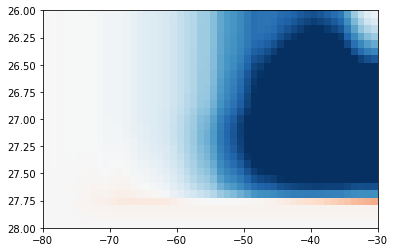

In [95]:
fig, ax = plt.subplots(nrows = 1, ncols = 1)
psi2 = psi.transpose('sigma0_outer', 'y')
psi2 = psi2/1e6
ax.pcolormesh(psi2.y, psi2.sigma0_outer, psi2, cmap = 'RdBu_r', vmin = -400, vmax = 400)
ax.invert_yaxis()

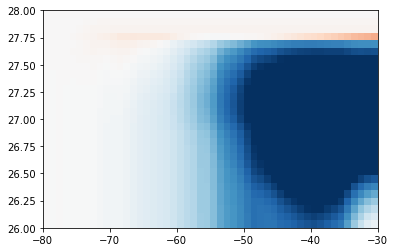

In [94]:
fig, ax = plt.subplots(nrows = 1, ncols = 1)

ax.pcolormesh(psi2.y, psi2.sigma0_outer, -1*psi2, cmap = 'RdBu_r', vmin = -400, vmax = 400)
ax.invert_yaxis()